### Get all URLs without specifying coordinates

In [182]:
import math
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Change file path
path = 'C:\\Users\\zhr19002\\Downloads\\'

# Get all URLs
pre_url = 'http://magnifier.flashphotography.com/MagnifyRender.ashx?X={}&Y={}&O=27226345&'
mid_urls = ['R=00001&F=0223','R=00003&F=0742','R=00003&F=0743','R=00003&F=0744']
post_url = '&A=71714'

for R in range(6,16):
    for F in range(1031,1033):
        mid_urls.append('R=' + str(R).zfill(5) + '&F=' + str(F))

urls = [pre_url + url + post_url for url in mid_urls]
urls = [urls[4]]

### Functions: Coordinates capture and image processing

In [183]:
# Function: Center point coordinates capture
def coordinates_capture(overlap):
    num_w = math.ceil((480 - overlap) / (117 - overlap)) + 1
    num_h = math.ceil((630 - overlap) / (117 - overlap)) + 1
    xs = [58*(2*i) - overlap*i + 1 for i in range(num_w)]
    ys = [58*(2*j) - overlap*j + 1 for j in range(num_h)]
    return xs, ys

# Fuction: Image cropping
def image_crop(url_0, x, y):
    url_1 = url_0.format(x, y)
    content = requests.get(url_1).content
    img = Image.open(BytesIO(content))
    crop_img = img.crop((36,36,153,153)) # Grab 117*117 px
    return crop_img

# Function: Image stitching
def image_stitch(imgs, xs, ys):
    target = Image.new('RGB', (117*len(xs), 117*len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            target.paste(imgs[len(ys)*i+j], (117*i, 117*j))
            crop_target = target.crop((0,0,480,630))
    return crop_target

# Fuction: Image stitching (up and down)
def image_stitch_UD(img1, img2, overlap):
    img1, img2 = np.float32(img1), np.float32(img2)
    # Calculate weights for each image
    weights1 = np.linspace(1, 0, overlap).reshape(-1, 1, 1)  # Weight for img1 decreases
    weights2 = np.linspace(0, 1, overlap).reshape(-1, 1, 1)  # Weight for img2 increases
    # Apply weighted smoothing to eliminate seams
    seam_smoothed = img1[-overlap:, :] * weights1 + img2[:overlap, :] * weights2
    # Combine images with only non-overlapping regions from each
    result = np.vstack((img1[:-overlap, :], seam_smoothed, img2[overlap:, :]))
    target = Image.fromarray(np.uint8(result))
    return target

# Fuction: Image stitching (left and right)
def image_stitch_LR(img1, img2, overlap):
    img1, img2 = np.float32(img1), np.float32(img2)
    # Calculate weights for each image
    weights1 = np.linspace(1, 0, overlap).reshape(1, -1, 1)  # Weight for img1 decreases
    weights2 = np.linspace(0, 1, overlap).reshape(1, -1, 1)  # Weight for img2 increases
    # Apply weighted smoothing to eliminate seams
    seam_smoothed = img1[:, -overlap:] * weights1 + img2[:, :overlap] * weights2
    # Combine images with only non-overlapping regions from each
    result = np.hstack((img1[:, :-overlap], seam_smoothed, img2[:, overlap:]))
    target = Image.fromarray(np.uint8(result))
    return target

### Save high-resolution pictures

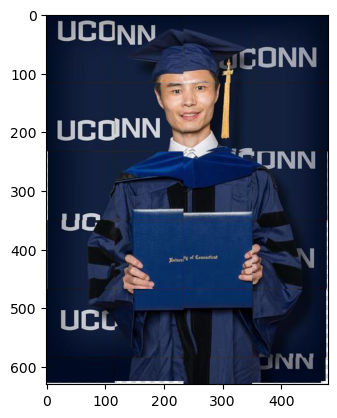

In [184]:
# It is wise to preload web pages with images to be processed to avoid unforseen errors
if __name__ == '__main__':
    # Center point coordinates
    xs = range(58, 58+117*5, 117)
    ys = range(58, 58+117*6, 117)

    # Run functions and save high-resolution pictures
    for ii in range(len(urls)):
        imgs = []
        for x in xs:
            for y in ys:
                imgs.append(image_crop(urls[ii], x, y))
        target_pic = image_stitch(imgs, xs, ys)
        plt.imshow(target_pic)
        plt.show()

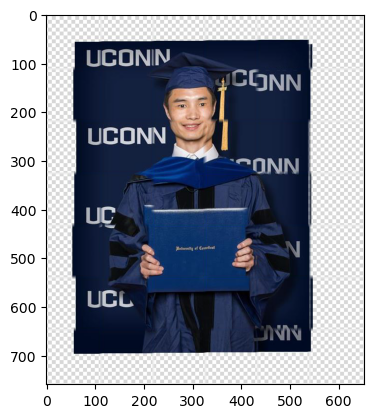

In [185]:
# It is wise to preload web pages with images to be processed to avoid unforseen errors
if __name__ == '__main__':
    overlap = 10
    # Center point coordinates
    (xs, ys) = coordinates_capture(overlap)
    
    # Run functions and save high-resolution pictures
    for i in range(len(urls)):
        himgs = []
        for x in xs:
            vimgs = []
            for y in ys:
                vimgs.append(image_crop(urls[i], x, y))
            vimg = image_stitch_UD(vimgs[0], vimgs[1], overlap)
            for vi in range(2, len(ys)):
                vimg = image_stitch_UD(vimg, vimgs[vi], overlap)
            himgs.append(vimg)
        himg = image_stitch_LR(himgs[0], himgs[1], overlap)
        for hi in range(2, len(xs)):
            himg = image_stitch_LR(himg, himgs[hi], overlap)
        target_pic = himg
        #target_pic.save(path + 'picture_' + str(i+1) + '.jpg', quality=95)
        
        plt.imshow(target_pic)
        plt.show()

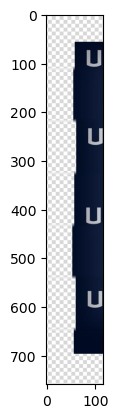

In [181]:
# It is wise to preload web pages with images to be processed to avoid unforseen errors
if __name__ == '__main__':
    overlap = 10
    # Center point coordinates
    (xs, ys) = coordinates_capture(overlap)
    
    # Run functions and save high-resolution pictures
    num = 0
    for i in range(len(urls)):
        himgs = []
        for x in [1]:
            vimgs = []
            for y in ys:
                num += 1
                image_crop(urls[i], x, y).save(path + str(num) + '.jpg', quality=95)
                vimgs.append(image_crop(urls[i], x, y))
            vimg = image_stitch_UD(vimgs[0], vimgs[1], overlap)
            for vi in range(2, len(ys)):
                vimg = image_stitch_UD(vimg, vimgs[vi], overlap)
            himgs.append(vimg)
        #himg = image_stitch_LR(himgs[0], himgs[1], overlap)
        #for hi in range(2, len(xs)):
            #himg = image_stitch_LR(himg, himgs[hi], overlap)
        target_pic = himgs[0]
        #target_pic.save(path + 'picture_' + str(i+1) + '.jpg', quality=95)
        
        plt.imshow(target_pic)
        plt.show()